# Bisecting K Means

#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Load the data

In [2]:
names = ["sepal_length", "sepal_width", "petal_length", "petal_width", "class"]
data = pd.read_csv("01-iris.data", names = names)
data = data.sample(frac = 1).reset_index(drop = True)    # shuffle the data
X = np.array(data.iloc[:, :4])
y = data.iloc[:, 4]
[m, n] = X.shape
data.head(5)

sepal_length  sepal_width  petal_length  petal_width           class
0           4.9          3.1           1.5          0.1     Iris-setosa
1           5.4          3.9           1.3          0.4     Iris-setosa
2           6.4          2.8           5.6          2.1  Iris-virginica
3           7.7          2.6           6.9          2.3  Iris-virginica
4           5.1          3.8           1.9          0.4     Iris-setosa

#### Randomly initialize centroids

In [3]:
def kMeansInitCentroids(X, K):
    # Randomly reorder the indices of examples
    perm = np.arange(X.shape[0])
    np.random.shuffle(perm)
    data_reorder = X[perm]
    
    # Take the first K examples as centroids
    return data_reorder[:K]

#### Find closest centroid

In [4]:
def findClosestCentroids(X, centroids):
    m = X.shape[0]
    K = centroids.shape[0]

    idx = np.zeros([m, 1])
    sicdIndividual = np.zeros(m)
    sicd = []

    # Find the new clusters
    for i in range(m):
        error_sum = np.sum((X[i] - centroids) ** 2, 1)
        sicdIndividual[i] = np.min(error_sum)
        idx[i] = np.argmin(error_sum)
    
    for i in range(K):
        sicd.append(sicdIndividual[(i == idx).flatten()].sum())
        
    return [idx, sicd]

#### Find new centroids

In [5]:
def computeCentroids(X, idx, K):
    [m, n] = X.shape
    centroids = np.zeros([K, n])

    # Calculate new centroids
    for i in range(K):
        points = X[(i == idx).flatten()]
        if (len(points) < 1): 
            centroids = np.zeros([1, n])
            continue
        centroids[i] = np.array([points.mean(axis = 0)])

    return centroids

#### Run K Means

In [6]:
def kMeans(X, K):
    centroids = kMeansInitCentroids(X, K)
    [m, n] = X.shape
    sicd = np.zeros(m)
    i = 0
    while True:
        [idx, sicdCurrent] = findClosestCentroids(X, centroids)
        sicd = sicdCurrent
        newCentroids = computeCentroids(X, idx, K)
        i += 1
        if (np.array_equal(newCentroids, centroids)):
            break
        centroids = newCentroids
    centroids = newCentroids
    
    clusters = []
    for k in range(K):
        clusters.append(X[(k == idx).flatten()])
    
    return { 
            "centroids": centroids, 
            "sicd": sicd, 
            "iterations": i,
            "clusters": clusters,
            "idx": idx
        }


#### Bisecting K Means

In [7]:
def bisectingKMeans(X, K):
    clusters = [X]
    sicd = [0]                # initially there is only one cluster
    centroids = [[]]
    idx = [[]]
    
    # Divide and compute until K centers are reached
    while (len(clusters) < K):
        sicdMaxPosition = sicd.index(max(sicd))
        result = kMeans(clusters[sicdMaxPosition], 2)
        
        # Now add the new clusters replacing the previous clusters
        clusters[sicdMaxPosition] = result["clusters"][1]
        clusters.insert(sicdMaxPosition, result["clusters"][0])
        centroids[sicdMaxPosition] = result["centroids"][1]
        centroids.insert(sicdMaxPosition, result["centroids"][0])
        sicd[sicdMaxPosition] = result["sicd"][1]
        sicd.insert(sicdMaxPosition, result["sicd"][0])
        
    return { "centroids": np.array(centroids), "sicd": sicd, "clusters": clusters }
        

## Clusters of the iris data set

In [8]:
K = 3
results = bisectingKMeans(X, K)
clusters = results["clusters"]
centroids = results["centroids"]
sicd = results["sicd"]

print("Found the centroids as: ")
for i in range(K):
        print("Cluster %i's centroid (%f, %f, %f, %f)" % 
              (i+1, centroids[i][0], centroids[i][1], centroids[i][2], centroids[i][3]))

print("\nClusters are as follows: ")
for cluster in list(map(lambda a : a.tolist()[:4], clusters)):
    print("Cluster 1: ")
    print(cluster, end = " ")
    print("...")

Found the centroids as: 
Cluster 1's centroid (5.950000, 2.763333, 4.473333, 1.453333)
Cluster 2's centroid (6.870270, 3.086486, 5.745946, 2.089189)
Cluster 3's centroid (5.005660, 3.360377, 1.562264, 0.288679)

Clusters are as follows: 
Cluster 1: 
[[5.6, 2.8, 4.9, 2.0], [6.3, 2.3, 4.4, 1.3], [5.9, 3.0, 5.1, 1.8], [5.8, 2.7, 5.1, 1.9]] ...
Cluster 1: 
[[6.4, 2.8, 5.6, 2.1], [7.7, 2.6, 6.9, 2.3], [7.9, 3.8, 6.4, 2.0], [6.7, 2.5, 5.8, 1.8]] ...
Cluster 1: 
[[4.9, 3.1, 1.5, 0.1], [5.4, 3.9, 1.3, 0.4], [5.1, 3.8, 1.9, 0.4], [5.4, 3.9, 1.7, 0.4]] ...


## Sum of the Intra-Cluster Distances (SICD)

In [9]:
prevSicd = sum(sicd)
print("Sum of squared error is %f" % prevSicd)

Sum of squared error is 84.276938


## Graphical representation of the obtained clusters

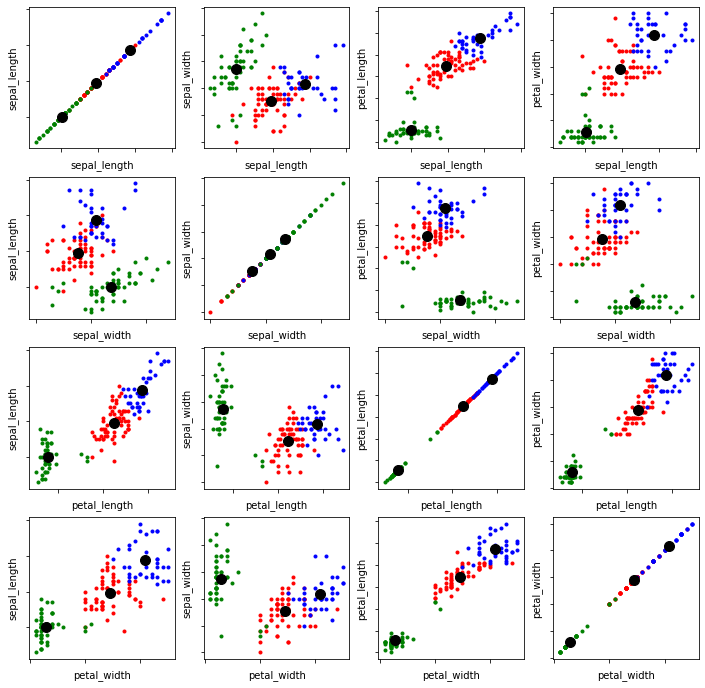

In [10]:
colors = [ "red", "blue", "green" ]
_, plots = plt.subplots(n, n, figsize = (12, 12))
for i in range(n):    
    for j in range(n):
        plots[i, j].set_xlabel(names[i])
        plots[i, j].set_ylabel(names[j])
        plots[i, j].set_xticklabels([])
        plots[i, j].set_yticklabels([])
        for k in range(K):
            selection = clusters[k]
            plots[i, j].scatter(selection[:, i], selection[:, j], color = colors[k], marker = ".")
        plots[i, j].scatter(centroids[:, i], centroids[:, j], color = "black", marker = "o", s = 100)

#### 500 iterations of Bisecting K Means

In [11]:
K = 3
iterations = 500
sicd = []
for i in range(iterations):
    newResults = bisectingKMeans(X, K)
        
    if (len(sicd) == 0 or sicd[len(sicd) - 1] > sum(newResults["sicd"])):
        sicd.append(sum(newResults["sicd"]))
        results = newResults
    else:
        sicd.append(sicd[len(sicd) - 1])
 

## Change in clustering solution and SICD

In [12]:
clusters = results["clusters"]
centroids = results["centroids"]

print("Found the centroids as: ")
for i in range(K):
        print("Cluster %i's centroid (%f, %f, %f, %f)" % 
              (i+1, centroids[i][0], centroids[i][1], centroids[i][2], centroids[i][3]))
        
print("\nSum of squared error is %f (previously %f)" % (sicd[iterations - 1], prevSicd))

print("\nClusters are as follows: ")
for cluster in list(map(lambda a : a.tolist()[:4], clusters)):
    print("Cluster 1: ")
    print(cluster, end = " ")
    print("...")
    

Found the centroids as: 
Cluster 1's centroid (5.005660, 3.360377, 1.562264, 0.288679)
Cluster 2's centroid (5.947458, 2.766102, 4.454237, 1.454237)
Cluster 3's centroid (6.850000, 3.073684, 5.742105, 2.071053)

Sum of squared error is 84.224507 (previously 84.276938)

Clusters are as follows: 
Cluster 1: 
[[4.9, 3.1, 1.5, 0.1], [5.4, 3.9, 1.3, 0.4], [5.1, 3.8, 1.9, 0.4], [5.4, 3.9, 1.7, 0.4]] ...
Cluster 1: 
[[5.6, 2.8, 4.9, 2.0], [6.3, 2.3, 4.4, 1.3], [5.9, 3.0, 5.1, 1.8], [5.8, 2.7, 5.1, 1.9]] ...
Cluster 1: 
[[6.4, 2.8, 5.6, 2.1], [7.7, 2.6, 6.9, 2.3], [7.9, 3.8, 6.4, 2.0], [6.7, 2.5, 5.8, 1.8]] ...


## Bisecting k-means iteration vs. SICD plot

In [22]:
K = 3
iterations = 500
sicdKMeans = []
for i in range(iterations):
    newKMeans = kMeans(X, K)
    
    if (len(sicdKMeans) == 0 or sicdKMeans[len(sicdKMeans) - 1] > sum(newKMeans["sicd"])):
        sicdKMeans.append(sum(newKMeans["sicd"]))
        kMeansResult = newKMeans
    else:
        sicdKMeans.append(sicdKMeans[len(sicdKMeans) - 1])
        

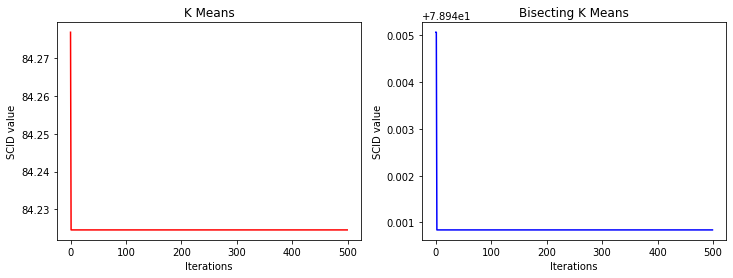

SICD values are:
    K Means          : 78.9408 
    Bisecting K Means: 84.2245


In [48]:
_, plots = plt.subplots(1, 2, figsize = (12, 4))
plots[1].set_title("Bisecting K Means")
plots[0].set_title("K Means")
plots[0].set_xlabel("Iterations")
plots[0].set_ylabel("SCID value")
plots[1].set_xlabel("Iterations")
plots[1].set_ylabel("SCID value")
plots[0].plot(np.arange(iterations), sicd, color = "red")
plots[1].plot(np.arange(iterations), sicdKMeans, color = "blue")
plt.show()

print("""SICD values are:
    K Means          : %.4f 
    Bisecting K Means: %.4f""" % (sicdKMeans[-1], sicd[-1]))